## 离散化


本节代码包括：
- 等频分箱
- 等距分箱
- 基于业务经验的分箱
- 基于决策树分箱

本节使用的数据集是titanic幸存者预测的数据。该文件已经上传至 /data 目录。

如需自己下载，下载地址[Kaggle website](https://www.kaggle.com/c/titanic/data)。 注意请下载 train.csv，并更名为 titanic.csv 放置在 /data 目录下。

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline

from sklearn.model_selection import train_test_split

### 等频分箱

In [3]:
data = pd.read_csv('../data/titanic.csv', usecols = ['Age', 'Fare', 'Survived'])
data.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [4]:
# 将 Age 字段分到5个bin里
Age_disccretised, intervals = pd.qcut(data.Age, 4, labels=None, retbins=True, precision=3, duplicates='raise')
pd.concat([Age_disccretised, data.Age], axis=1).head(10)

,Age,Age
0,"(20.125, 28.0]",22.0
1,"(28.0, 38.0]",38.0
2,"(20.125, 28.0]",26.0
3,"(28.0, 38.0]",35.0
4,"(28.0, 38.0]",35.0
5,NaN,NaN
6,"(38.0, 80.0]",54.0
7,"(0.419, 20.125]",2.0
8,"(20.125, 28.0]",27.0
9,"(0.419, 20.125]",14.0


In [5]:
# 划分的区间
intervals

array([  0.42 ,  20.125,  28.   ,  38.   ,  80.   ])

In [6]:
#  每一个区间内的样本量基本是相等的

temp = pd.concat([Age_disccretised, data.Age], axis=1)
temp.columns = ['Age_discretised', 'Age']
temp.groupby('Age_discretised')['Age'].count()

Age_discretised
(0.419, 20.125]    179
(20.125, 28.0]     183
(28.0, 38.0]       175
(38.0, 80.0]       177
Name: Age, dtype: int64

In [7]:
# 在分箱的时候也可以直接替换为标签
Age_disccretised, intervals = pd.qcut(data.Age, 4, labels=['Q1', 'Q2', 'Q3', 'Q4'], retbins=True, precision=3, duplicates='raise')
Age_disccretised.head()

0    Q2
1    Q3
2    Q2
3    Q3
4    Q3
Name: Age, dtype: category
Categories (4, object): [Q1 < Q2 < Q3 < Q4]

###  等距分箱

In [9]:
# 分割训练集测试集
X_train, X_test, y_train, y_test = train_test_split(data[['Age', 'Fare', 'Survived']], data.Survived, test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((623, 3), (268, 3))

In [10]:
# Age 字段的极差
Age_range = X_train.Age.max() - X_train.Age.min()
Age_range

79.329999999999998

In [11]:
# 计算边界
min_value = int(np.floor(X_train.Age.min()))
max_value = int(np.ceil(X_train.Age.max()))

# 计算每个区间的宽度
inter_value = int(np.round(Age_range/10))

min_value, max_value, inter_value

(0, 80, 8)

In [12]:
# 计算每个区间的上下界
intervals = [i for i in range(min_value, max_value+inter_value, inter_value)]
intervals

[0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80]

In [13]:
# 制作标签
labels = ['Bin_'+str(i) for i in range(1,len(intervals))]
labels

['Bin_1',
 'Bin_2',
 'Bin_3',
 'Bin_4',
 'Bin_5',
 'Bin_6',
 'Bin_7',
 'Bin_8',
 'Bin_9',
 'Bin_10']

In [14]:
# 创建区间
# create one column with labels
X_train['Age_disc_labels'] = pd.cut(x = X_train.Age, bins=intervals, labels=labels, include_lowest=True)

# and one with bin boundaries
X_train['Age_disc'] = pd.cut(x = X_train.Age, bins=intervals, include_lowest=True)

X_train.head()

,Age,Fare,Survived,Age_disc_labels,Age_disc
857,51.0,26.5500,1,Bin_7,"(48.0, 56.0]"
52,49.0,76.7292,1,Bin_7,"(48.0, 56.0]"
386,1.0,46.9000,0,Bin_1,"(-0.001, 8.0]"
124,54.0,77.2875,0,Bin_7,"(48.0, 56.0]"
578,NaN,14.4583,0,NaN,NaN


In [15]:
# 观察每个区间的样本数
X_train.groupby('Age_disc')['Age'].count()

Age_disc
(-0.001, 8.0]     40
(8.0, 16.0]       29
(16.0, 24.0]     119
(24.0, 32.0]     118
(32.0, 40.0]      90
(40.0, 48.0]      53
(48.0, 56.0]      28
(56.0, 64.0]      17
(64.0, 72.0]       6
(72.0, 80.0]       2
Name: Age, dtype: int64

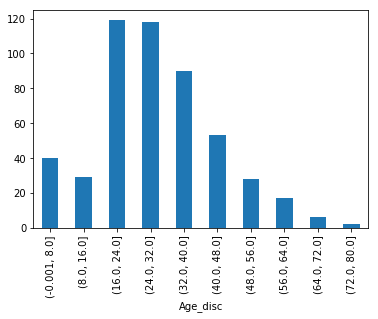

In [16]:
# 直方图
X_train.groupby('Age_disc')['Age'].count().plot.bar()

### 基于业务经验的分箱

In [17]:
data.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [18]:
# 观察 Age 的分布
data.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [19]:
# 用自定义的区间分箱

# bucket boundaries
buckets = [0,20,40,60,1000]

# bucket labels
labels = ['0-20', '20-40', '40-60', '>60']

# discretisation
data['Age_buckets_labels'] = pd.cut(data.Age, bins=buckets, labels = labels, include_lowest=True)
data['Age_buckets'] = pd.cut(data.Age, bins=buckets, include_lowest=True)

data.head()

,Survived,Age,Fare,Age_buckets_labels,Age_buckets
0,0,22.0,7.2500,20-40,"(20.0, 40.0]"
1,1,38.0,71.2833,20-40,"(20.0, 40.0]"
2,1,26.0,7.9250,20-40,"(20.0, 40.0]"
3,1,35.0,53.1000,20-40,"(20.0, 40.0]"
4,0,35.0,8.0500,20-40,"(20.0, 40.0]"


In [20]:
data.tail()

,Survived,Age,Fare,Age_buckets_labels,Age_buckets
886,0,27.0,13.00,20-40,"(20.0, 40.0]"
887,1,19.0,30.00,0-20,"(-0.001, 20.0]"
888,0,NaN,23.45,NaN,NaN
889,1,26.0,30.00,20-40,"(20.0, 40.0]"
890,0,32.0,7.75,20-40,"(20.0, 40.0]"


#### 基于决策树的分箱


In [22]:
# 分割训练集测试集

X_train, X_test, y_train, y_test = train_test_split(data[['Age', 'Fare', 'Survived']],
                                                    data.Survived, test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((623, 3), (268, 3))

In [23]:
# 用随机值填补缺失
def impute_na(data, variable):
    df = data.copy()
    
    # random sampling
    df[variable+'_random'] = df[variable]
    # extract the random sample to fill the na
    random_sample = X_train[variable].dropna().sample(df[variable].isnull().sum(), random_state=0)
    # pandas needs to have the same index in order to merge datasets
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable+'_random'] = random_sample
    
    return df[variable+'_random']

In [24]:
X_train['Age'] = impute_na(data, 'Age')
X_test['Age'] = impute_na(data, 'Age')

In [25]:
# 决策树模型
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier, export_graphviz

tree_model = DecisionTreeClassifier(max_depth=2)  # 2层
tree_model.fit(X_train.Age.to_frame(), X_train.Survived)
X_train['Age_tree'] = tree_model.predict_proba(X_train.Age.to_frame())[:,1]
X_train.head(10)

,Age,Fare,Survived,Age_tree
857,51.0,26.5500,1,0.370849
52,49.0,76.7292,1,0.370849
386,1.0,46.9000,0,0.516667
124,54.0,77.2875,0,0.370849
578,14.5,14.4583,0,0.818182
549,8.0,36.7500,1,0.516667
118,24.0,247.5208,0,0.370849
12,20.0,8.0500,0,0.370849
157,30.0,8.0500,0,0.370849
127,24.0,7.1417,1,0.370849


In [26]:
# 2层 * 2 叶子，共4个叶子节点
X_train.Age_tree.unique()

array([ 0.37084871,  0.51666667,  0.81818182,  0.1       ])

In [27]:
# 观察4个叶子上所构成的区间
pd.concat( [X_train.groupby(['Age_tree'])['Age'].min(),
            X_train.groupby(['Age_tree'])['Age'].max()], axis=1)

,Age,Age
Age_tree,,
0.100000,64.00,80.0
0.370849,16.00,63.0
0.516667,0.67,11.0
0.818182,12.00,15.0


4个区间：0-11，12-15，16-63，46-80 分别对应的生存概率是 .51 .81 .37 和 .10